In [1]:
from torch.utils.data import Dataset
import os
import numpy as np
from scipy import fftpack as fft
import cv2
import pandas as pd
import torch
import matplotlib.pyplot as plt
print(torch.cuda.is_available())
torch.cuda.empty_cache()  

True


In [2]:
dir = '/kaggle/input/ultra-wide-band-pose-prediction/'
# dir_img = '/kaggle/input/save-fig/'
dir_img = '/kaggle/input/uwb-oricolor/'

# Import Dataset

In [3]:
classes = ["fall", "jump", "not_fall", "run", "run_sit", "sit_run", "walk"]

class CSVdatagen(Dataset):
    def __init__(self, csv=f'{dir}annotations.csv', src=f'{dir}train/train'):
        self.csv = pd.read_csv(csv).fillna(-1)
        self.src = src

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        row = self.csv.iloc[idx]
        iq = np.load(os.path.join(self.src, row['id'] + '.npy'))
        if iq.shape[0] > 2560:
            iq = iq[-2560:]
        image = np.transpose(np.abs(iq))
        
        return image, row['class']
        
dset = CSVdatagen()
data_, _ = dset[0]

In [4]:
dat, cl = dset[500]

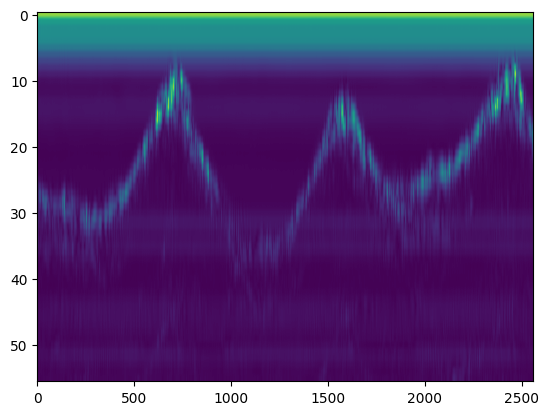

In [5]:
plt.imshow(dat, aspect='auto')

In [6]:
dset.csv

,id,class
0,80a8dc1d-b216-469c-91b1-fc257562a883,0
1,3ab012da-927a-40d6-95f8-5a2f96dad360,0
2,eef92f84-5127-4063-a4a2-fee4035b1ac7,0
3,8d562739-6502-4a6c-8b83-e029b795f685,0
4,404c2e92-1101-4e62-83bf-a6fdb7dfcb9a,0
...,...,...
642,ea5513a7-f18a-4393-8ab4-44e574e70f2b,4
643,edf4aec3-410d-4ed3-90d2-12671bb4c625,4
644,297e1f02-66ac-4e4e-849a-da2f1103e8a0,4
645,926418bb-2e66-4c82-82b1-13a82faf73b4,4


# Export to images

In [7]:
# import os
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# dset = CSVdatagen()
# output_dir = "images_jet/train" 

# dpi = 100                    # DPI for the output image
# height = 224                 # Image height
# width = 640                  # Image width

# # Make sure the output directory exists
# os.makedirs(output_dir, exist_ok=True)

# for i in range(len(dset)):
#     data_, class_ = dset[i]
#     # Assuming the dataset class gives access to the original file name; adjust as needed
#     original_file_name = dset.csv.iloc[i]['id'] + '.png'  # Construct the file name for saving

#     # SAVE FIG
#     fig, axs = plt.subplots(1, 1)#, figsize=(width/dpi, height/dpi), dpi=dpi)
#     axs.imshow(data_, cmap='jet', aspect='auto')  # Select your colormap
#     axs.axis('off')

#     # Save the figure using the original file name in the specified output directory
#     fig.savefig(os.path.join(output_dir, original_file_name), bbox_inches='tight', pad_inches=0)
#     plt.close(fig)


In [8]:
# dset = CSVdatagen(csv='sample_submission.csv',src='test/test')
# output_dir = "images_jet/test"  
# dpi = 100                    # DPI for the output image
# height = 224                 # Image height
# width = 640                  # Image width

# # Make sure the output directory exists
# os.makedirs(output_dir, exist_ok=True)

# for i in range(len(dset)):
#     data_, class_ = dset[i]
#     # Assuming the dataset class gives access to the original file name; adjust as needed
#     original_file_name = dset.csv.iloc[i]['id'] + '.png'  # Construct the file name for saving

#     # SAVE FIG
#     fig, axs = plt.subplots(1, 1)#, figsize=(width/dpi, height/dpi), dpi=dpi)
#     axs.imshow(data_, cmap='jet', aspect='auto')  # Select your colormap
#     axs.axis('off')

#     # Save the figure using the original file name in the specified output directory
#     fig.savefig(os.path.join(output_dir, original_file_name), bbox_inches='tight', pad_inches=0)
#     plt.close(fig)


# BG subtract

In [9]:
# from PIL import Image
# import numpy as np
# import os
# from tqdm import tqdm

# # Define the directories
# test_dir = "images/test"  # Replace with the path to your 'test' directory
# train_dir = "images/train"  # Replace with the path to your 'train' directory
# test_output_dir = "images_jet_glob/test"  # Replace with the path to save the 'test' output
# train_output_dir = "images_jet_glob/train"  # Replace with the path to save the 'train' output

# # Create output directories if they do not exist
# os.makedirs(test_output_dir, exist_ok=True)
# os.makedirs(train_output_dir, exist_ok=True)

# def calculate_global_mean(directories):
#     global_sum = None
#     count = 0
#     for image_dir in directories:
#         file_list = os.listdir(image_dir)
#         for file_name in tqdm(file_list):
#             img = Image.open(os.path.join(image_dir, file_name))
#             img_array = np.array(img, dtype=np.float64)
#             if global_sum is None:
#                 global_sum = np.zeros_like(img_array)
#             global_sum += img_array
#             count += 1
#     global_mean = global_sum / count
#     return global_mean

# # Calculate the single global mean across both directories
# global_mean = calculate_global_mean([test_dir, train_dir])

# # Function to process images in a directory
# def process_images(image_dir, output_dir, global_mean):
#     file_list = os.listdir(image_dir)
#     for file_name in tqdm(file_list):
#         img = Image.open(os.path.join(image_dir, file_name))
#         img_array = np.array(img).astype(np.float32)

#         # Subtract the global mean from the image
#         adjusted_data = img_array - global_mean

#         # Normalize the image data
#         min_val = np.min(adjusted_data)
#         max_val = np.max(adjusted_data)
#         if max_val - min_val > 0:  # Avoid division by zero
#             adjusted_data = 255 * (adjusted_data - min_val) / (max_val - min_val)

#         # Convert to uint8 and save the adjusted image
#         adjusted_image = Image.fromarray(adjusted_data.astype(np.uint8))
#         adjusted_image.save(os.path.join(output_dir, file_name))

# # Process and save the adjusted images
# process_images(test_dir, test_output_dir, global_mean)
# process_images(train_dir, train_output_dir, global_mean)


# Model

In [10]:
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
import torchvision.transforms as transforms

class CSVimage_datagen(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_labels = pd.read_csv(csv_file).fillna(-1)
        self.img_dir = img_dir
        self.transform = transform
        

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path+'.png').convert('RGB')  # Convert to RGB in case of grayscale images
        label = self.img_labels.iloc[idx, 1]  # Adjust the index based on your CSV structure
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [11]:
from torch import nn
from timm.models import convnext
import timm

MODEL_NAME = 'convnext_small_fold_oricolor'

class ViTCls(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = convnext.convnext_small(pretrained=True)
        self.cls = nn.Linear(self.encoder.num_features, 7)

    def forward(self, images):
        x = self.encoder.forward_features(images)
        x = self.encoder.forward_head(x, pre_logits=True)
        y = self.cls(x)
        return y

# Training

In [12]:
from torch.utils.data import DataLoader
from torch import nn
import torch
from timm.scheduler.cosine_lr import CosineLRScheduler
import tensorflow as tf
from sklearn.model_selection import KFold
import pandas as pd
from sklearn.metrics import classification_report
import json
import warnings
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import json
from sklearn.metrics import classification_report, f1_score
import numpy as np

warnings.filterwarnings("ignore")
imagepath= f'{dir_img}images_oricolor/' #f'{dir_img}images/'

# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Initial settings
n_epochs = 15
batch_size = 8
n_folds = 5
device = 'cuda'
# model = ViTCls().to(device)
data = {'fold': [], 'epoch': [], 'acc': [], 'val_acc_total':[]}

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor(),
    # Add more transforms as needed
])

# Instantiate the dataset
train_val_dataset = CSVimage_datagen(csv_file=f'{dir}annotations.csv', img_dir=f'{imagepath}train', transform=transform)

# Cross-Validation setup
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

fold_results = []  # Optionally collect fold results

for fold, (train_indices, val_indices) in enumerate(kf.split(range(len(train_val_dataset)))):
    print(f"Fold {fold+1}/{n_folds}")
    
    #Create UWBImageDataset instances for training and validation sets
    train_dataset = Subset(train_val_dataset, train_indices)
    val_dataset = Subset(train_val_dataset, val_indices)
    
    # Create DataLoader instances
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    # Initialize model and optimizer for each fold
    model = ViTCls().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    # Adjust the scheduler as needed
    schedule = CosineLRScheduler(optimizer, t_initial=n_epochs, cycle_mul=1,
                             lr_min=1e-6, cycle_decay=0.1, warmup_lr_init=1e-7,
                             warmup_t=10, cycle_limit=1, t_in_epochs=True,
                             noise_range_t=None,)
    
    # Reset the best validation accuracy for the fold
    best_val_acc = 0
    best_model_state = None
    
    # Accumulators for true and predicted labels
    true_labels = []
    predicted_labels = []

    for epoch in range(n_epochs):
        print(f'epoch:{epoch}/{n_epochs}')
        # Training with progress bar
        model.train()
        train_progbar = tf.keras.utils.Progbar(len(train_loader))
        for idx, (x, cls) in enumerate(train_loader):
            x, cls = x.to(device), cls.to(device)
            
            optimizer.zero_grad()
            logit = model(x)
            loss = criterion(logit, cls)
            loss.backward()
            optimizer.step()
            
            _, predicted = logit.max(1)
            acc = (predicted.eq(cls).sum().item()) / cls.size(0)
            
            # Update progress bar
            train_printlog = [('loss', loss.item()), ('acc', acc)]
            train_progbar.update(idx + 1, values=train_printlog)
            
        # Step the scheduler after each epoch
        schedule.step(epoch + 1)

        # Before starting validation, let's ensure the variables are indeed lists
        true_labels = []  # Resetting as lists again to be doubly sure
        predicted_labels = []
    
        # Validation with progress bar
        val_acc_total = 0  # Initialize validation accuracy total for the epoch
        model.eval()
        val_progbar = tf.keras.utils.Progbar(len(val_loader))
        with torch.no_grad():
            for idx, (x, cls) in enumerate(val_loader):
                x = x.to(device).float()
                cls = cls.to(device)
                logit = model(x)
                _, predicted = logit.max(1)
                val_acc_total += predicted.eq(cls).sum().item() / cls.size(0)

                # # Debugging print statement to check variable types
                # print(f"Type of true_labels: {type(true_labels)}, Type of predicted_labels: {type(predicted_labels)}")
            
                # Convert to list and extend
                true_labels_list = cls.cpu().numpy().tolist()  # Ensure conversion to list here
                predicted_labels_list = predicted.cpu().numpy().tolist()  # Ensure conversion to list here
            
                true_labels.extend(true_labels_list)
                predicted_labels.extend(predicted_labels_list)
                
                val_printlog = [('val_acc', val_acc_total / (idx + 1))]
                val_progbar.update(idx + 1, val_printlog)
                
    # After completing the epochs for a fold, calculate and print the F1 score
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calculate F1 score for each class and the average F1 score
    # Note: Setting average=None calculates F1 for each class;
    # average='macro' calculates unweighted mean F1 score
    f1_scores = f1_score(true_labels, predicted_labels, average=None)
    avg_f1_score = f1_score(true_labels, predicted_labels, average='macro')

    # Print classification report for the fold (optional)
    print(f"Classification Report for Fold {fold+1}:")
    print(classification_report(true_labels, predicted_labels))

    # Add results to fold_results
    fold_result = {
        'fold': fold + 1,
        'val_acc': best_val_acc,
        'avg_f1_score': avg_f1_score,
        'f1_scores_per_class': f1_scores.tolist(),  # Convert to list for JSON compatibility
    }
    fold_results.append(fold_result)

    # Calculate average validation accuracy and update best model
    current_val_acc = val_acc_total / len(val_loader)
    if current_val_acc > best_val_acc:
        best_val_acc = current_val_acc
        best_model_state = model.state_dict().copy()

    # Append epoch data to the data dictionary for the current fold
    data['fold'].append(fold)  # Use the actual fold index
    data['epoch'].append(epoch + 1)
    data['val_acc_total'].append(current_val_acc)
    data['acc'].append(acc)  # Make sure 'acc' is updated in your training loop
        
    # save results
    save_folder = f'/kaggle/working/logs/{MODEL_NAME}'
    os.makedirs(save_folder, exist_ok=True)  
        
    with open(f'{save_folder}/fold_results.json', 'w') as f:
        json.dump(fold_results, f, indent=4)
        
    if best_model_state is not None:
        fold_save_path = os.path.join(save_folder, f'best_model_fold_{fold+1}.pth')
        torch.save(best_model_state, fold_save_path)

    save_path = f'{save_folder}/fold_record_{fold+1}.txt'
    with open(save_path, 'w') as f:
        json.dump(data, f)

2024-02-17 16:38:17.459867: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 16:38:17.459967: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 16:38:17.619727: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Fold 1/5


model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

epoch:0/15
17/17 [==============================] - 2s 131ms/step - val_acc: 0.2255
epoch:1/15
17/17 [==============================] - 1s 81ms/step - val_acc: 0.5594
epoch:2/15
17/17 [==============================] - 1s 82ms/step - val_acc: 0.6386
epoch:3/15
17/17 [==============================] - 1s 81ms/step - val_acc: 0.4845
epoch:4/15
17/17 [==============================] - 1s 83ms/step - val_acc: 0.6123
epoch:5/15
17/17 [==============================] - 1s 81ms/step - val_acc: 0.6648
epoch:6/15
17/17 [==============================] - 1s 80ms/step - val_acc: 0.6414
epoch:7/15
17/17 [==============================] - 1s 83ms/step - val_acc: 0.6386
epoch:8/15
17/17 [==============================] - 1s 82ms/step - val_acc: 0.8243
epoch:9/15
17/17 [==============================] - 1s 82ms/step - val_acc: 0.6738
epoch:10/15
17/17 [==============================] - 1s 84ms/step - val_acc: 0.7969
epoch:11/15
17/17 [==============================] - 1s 85ms/step - val_acc: 0.8037
e

## Find a model from Max Avg F1 Score

In [13]:
import json

# Path to your JSON file
json_file_path = f'{save_folder}/fold_results.json'

# Open the JSON file and load its contents
with open(json_file_path, 'r') as file:
    read_fold_results = json.load(file)

# Initialize variables to track the maximum F1 score and corresponding fold
max_f1_score = 0
max_f1_fold = 0

# Extract 'fold' and 'avg_f1_score' and print them
for item in read_fold_results:
    if item['avg_f1_score'] > max_f1_score:
        max_f1_score = item['avg_f1_score']
        max_f1_fold = item['fold']
        
    # fold = item['fold']
    # avg_f1_score = item['avg_f1_score']
    # print(f"Fold: {fold}, Avg F1 Score: {avg_f1_score}")

print(f"Fold with max Avg F1 Score: {max_f1_fold}, Max Avg F1 Score: {max_f1_score}")
model_path = f'{save_folder}/best_model_fold_{max_f1_fold}.pth' 
print(model_path)

Fold with max Avg F1 Score: 4, Max Avg F1 Score: 0.9097733004891445
/kaggle/working/logs/convnext_small_fold_oricolor/best_model_fold_4.pth


# Testing

In [14]:
test_dataset = CSVimage_datagen(csv_file=f'{dir}sample_submission.csv', img_dir=f'{imagepath}test', transform=transform)
test_dataset.img_labels = test_dataset.img_labels.fillna(-1)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
print(len(train_dataset), len(val_dataset), len(test_dataset))

518 129 164


In [15]:
# Testing
model = ViTCls().to(device)  # Re-instantiate the model
model_path = f'{save_folder}/best_model_fold_{max_f1_fold}.pth' 
print(model_path)

# Load the state dict from the file
state_dict = torch.load(model_path)

# Load the state dict into the model
model.load_state_dict(state_dict)

test_results_df = pd.read_csv(f'{dir}sample_submission.csv')

model.eval()
test_progbar = tf.keras.utils.Progbar(len(test_loader))
predictions = []
with torch.no_grad():
    for idx, (x, cls) in enumerate(test_loader):
        x = x.to(device).float()
        cls = cls.to(device)
        logit = model(x)
        _, predicted = logit.max(1)
        predictions.extend(predicted.cpu().numpy().tolist())
        test_progbar.update(idx + 1)

# After testing, save your results to a CSV file
test_results_df['class']= predictions
test_results_df.to_csv(f'/kaggle/working/{MODEL_NAME}_predictions.csv', index=False)

/kaggle/working/logs/convnext_small_fold_oricolor/best_model_fold_4.pth
21/21 [==============================] - 3s 141ms/step


100%|██████████| 17/17 [00:01<00:00, 12.13it/s]


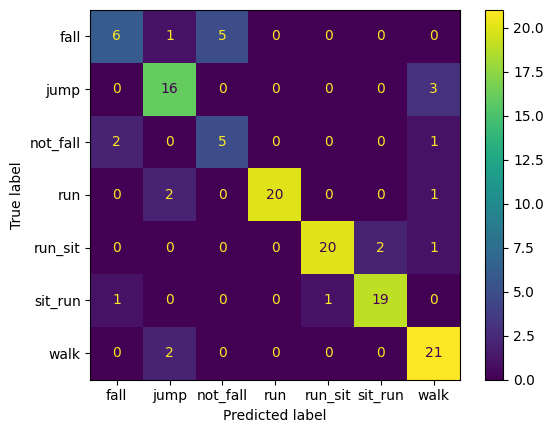

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm  

predictions = []
references = []

model.load_state_dict(best_model_state)
model.eval()

model.eval()
with torch.no_grad():
    for batch in tqdm(val_loader):
        inputs, targets = batch
        outputs = model(inputs.to(device))

        # Log Values
        predictions += outputs.argmax(-1).detach().cpu().tolist()
        references += targets.tolist()

cm = confusion_matrix(references, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=classes)
disp.plot()

# Save the plot
plt.savefig(os.path.join(save_folder, 'confusion_matrix.png'))
plt.show()
# plt.close(fig)  # Close the plot figure to free memory

# Implement Voting

In [17]:
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from scipy import stats

# Assuming the CSVimage_datagen and ViTCls classes, along with other necessary imports and variables, are defined elsewhere

# Initialize test dataset and loader
test_dataset = CSVimage_datagen(csv_file=f'{dir}sample_submission.csv', img_dir=f'{imagepath}test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Prepare to collect predictions from each fold
fold_predictions = []

for fold in range(1, n_folds + 1):
    # Load the model for the current fold
    model = ViTCls().to(device)
    model_path = f'{save_folder}/best_model_fold_{fold}.pth'
    model.load_state_dict(torch.load(model_path))
    
    model.eval()
    fold_pred = []
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            logit = model(x)
            _, predicted = logit.max(1)
            fold_pred.append(predicted.cpu().numpy())
    
    fold_predictions.append(np.concatenate(fold_pred))

# Convert list of numpy arrays to a numpy array for easier manipulation
fold_predictions_array = np.array(fold_predictions)

# Use mode to find the most common prediction across folds for each sample
voted_predictions, _ = stats.mode(np.array(fold_predictions), axis=0)

# Flatten the array of voted predictions to match the expected shape for saving to CSV
voted_predictions = voted_predictions.flatten()

# Continue with saving voted_predictions to CSV as before
test_results_df['class'] = voted_predictions
test_results_df.to_csv(f'/kaggle/working/vote_prediction.csv', index=False)

print(f"Voted predictions saved to /kaggle/working/vote_prediction.csv")

Voted predictions saved to /kaggle/working/vote_prediction.csv


In [18]:
test_results_df

,id,class
0,30de3513-93ff-42d8-ad5f-4c93f4a4444c,3
1,84e55af1-ae63-4b06-b650-1136d38b691e,5
2,2471a7eb-af35-4ae7-870e-6650de9f0c2f,2
3,d00e8bdc-79af-4e55-b25a-96ea589b6420,4
4,ad9f77bc-5ab6-477d-b760-2f3fc65c14d3,0
...,...,...
159,5fce955d-1068-40b3-afc3-111f8c22c9f9,3
160,f3a000be-07c9-44ad-8ff0-b89a9a1070dd,4
161,84d3963b-cfed-450c-88ab-ca853273d15c,1
162,7b36184c-5541-44d9-9200-8057bd3cf4ef,6
